## 1. An MNIST Classifier With Over 97% Accuracy

Exercise: _Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters)._

In [57]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [58]:
from sklearn.model_selection import train_test_split

X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.2)

In [59]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56000, 784), (14000, 784), (56000,), (14000,))

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

knn_clf = KNeighborsClassifier(n_neighbors=3, weights='distance')

In [61]:
cross_val_score(knn_clf, X_train, y_train, cv=5, scoring='accuracy')

array([0.97258929, 0.96848214, 0.97169643, 0.96946429, 0.97196429])

In [62]:
knn_clf.fit(X_train, y_train)
knn_clf_preds = knn_clf.predict(X_test)

In [63]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, knn_clf_preds)

0.9737857142857143

## 2. Data Augmentation

Exercise: _Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. You can use the `shift()` function from the `scipy.ndimage` module. For example, `shift(image, [2, 1], cval=0)` shifts the image two pixels down and one pixel to the right. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called _data augmentation_ or _training set expansion_._

In [64]:
X_train.shape

(56000, 784)

In [65]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis(False)

In [66]:
from scipy.ndimage import shift
import numpy as np

In [67]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted_image.reshape([-1])

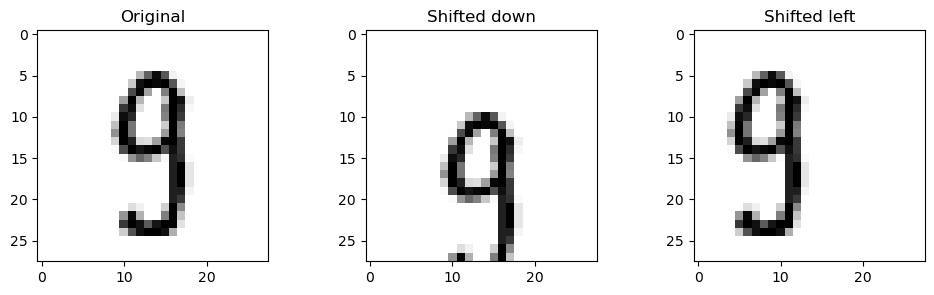

In [68]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation='nearest', cmap='binary')
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation='nearest', cmap='binary')
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation='nearest', cmap='binary');

In [69]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [70]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [71]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [72]:
knn_aug_preds = knn_clf.predict(X_test)

In [73]:
accuracy_score(y_test, knn_aug_preds)

0.9791428571428571

## 3. Tackle the Titanic dataset

Exercise: _Tackle the Titanic dataset. A great place to start is on [Kaggle](https://www.kaggle.com/c/titanic). Alternatively, you can download the data from https://homl.info/titanic.tgz and unzip this tarball like you did for the housing data in Chapter 2. This will give you two CSV files: _train.csv_ and _test.csv_ which you can load using `pandas.read_csv()`. The goal is to train a classifier that can predict the `Survived` column based on the other columns._

In [74]:
import pandas as pd 
from pathlib import Path

path = Path('datasets/titanic')
train_df = pd.read_csv(path / 'train.csv')
test_df = pd.read_csv(path / 'test.csv')

In [75]:
train_df.shape, test_df.shape

((891, 12), (418, 11))

In [76]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [77]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [78]:
train_labels = train_df['Survived']

In [79]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False),
)

num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessing = ColumnTransformer([
    ('drop_column', 'drop', ['Name', 'Ticket', 'Cabin', 'Survived']),
    ('cat', cat_pipeline, ['Pclass', 'Sex', 'Embarked']),
    ('num', num_pipeline, ['Age', 'SibSp', 'Parch', 'Fare'])
])

In [80]:
train_prepared = preprocessing.fit_transform(train_df)

In [81]:
preprocessing.get_feature_names_out()

array(['cat__Pclass_1', 'cat__Pclass_2', 'cat__Pclass_3',
       'cat__Sex_female', 'cat__Sex_male', 'cat__Embarked_C',
       'cat__Embarked_Q', 'cat__Embarked_S', 'num__Age', 'num__SibSp',
       'num__Parch', 'num__Fare'], dtype=object)

In [82]:
from sklearn.ensemble import RandomForestClassifier

forest_reg = make_pipeline(preprocessing,
                           RandomForestClassifier())
forest_scores = cross_val_score(forest_reg, train_df, train_labels, scoring='accuracy', cv=10)

In [83]:
forest_scores.mean()

0.8036704119850187

In [84]:
from sklearn.linear_model import SGDClassifier

sgd_clf = make_pipeline(preprocessing,
                        SGDClassifier())
sgd_acc = cross_val_score(sgd_clf, train_df, train_labels, scoring='accuracy', cv=10)

In [85]:
sgd_acc.mean()

0.7317852684144819

In [86]:
from sklearn.svm import SVC

svm_clf = make_pipeline(preprocessing,
                        SVC(gamma='auto'))
svm_scores = cross_val_score(svm_clf, train_df, train_labels, scoring='accuracy', cv=10)

In [87]:
svm_scores.mean()

0.8260549313358302

/tmp/ipykernel_12349/2005685735.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([svm_scores, forest_scores], labels=('SVM', 'Random Forest'))


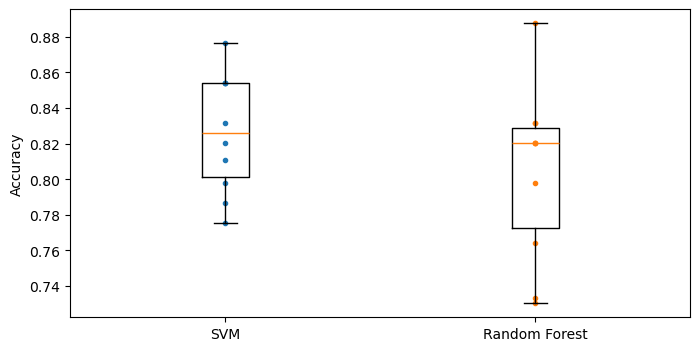

In [97]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, '.')
plt.plot([2]*10, forest_scores, '.')
plt.boxplot([svm_scores, forest_scores], labels=('SVM', 'Random Forest'))
plt.ylabel('Accuracy');